In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gc  # Python Garbage Collector
import os
import shutil
import zipfile
from PIL import Image
from io import BytesIO
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

# Custom Dataset 정의
class ZipDataset(Dataset):
    def __init__(self, zip_file, transform=None, original_transform=None):
        self.zip_file = zipfile.ZipFile(zip_file, 'r')  # ZIP 파일 오픈
        self.image_names = [
            name for name in self.zip_file.namelist() if name.endswith(('.jpg', '.png'))
        ]  # 이미지 파일만 필터링
        self.transform = transform or transforms.ToTensor()
        self.original_transform = original_transform or transforms.ToTensor()  # 기본 변환 설정
        
        print(f"총 {len(self.image_names)}개의 이미지 파일이 탐색되었습니다.")  # 디버깅용 출력

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_data = self.zip_file.read(img_name)  # ZIP 내부의 이미지 파일 읽기
        original_image = Image.open(BytesIO(img_data))  # Bytes 데이터를 PIL 이미지로 변환

        # 원본 이미지를 변환 없이 저장
        if self.original_transform:
            original_image_tensor = self.original_transform(original_image)
        else:
            original_image_tensor = original_image

        # 변환된 이미지를 생성
        if self.transform:
            image = self.transform(original_image)
        else:
            image = original_image_tensor

        return image, original_image_tensor  # 변환된 이미지와 원본 텐서를 반환

# Transform 정의
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # 이미지 크기를 28x28로 조정
    transforms.ToTensor(),
])

original_transform = transforms.Compose([
    transforms.ToTensor(),  # 원본 이미지는 크기 변경 없이 텐서로만 변환
])

# 압축 파일 경로
zip_file_path = r"C:\Users\seongmun\Downloads\archive.zip"

# 데이터셋 및 데이터로더 생성
dataset = ZipDataset(zip_file=zip_file_path, transform=transform, original_transform=original_transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

# 데이터 확인 (테스트)
for batch_idx, (data, original) in enumerate(data_loader):
    print(f"Batch {batch_idx + 1}: 변환된 이미지 크기: {data.size()}, 원본 이미지 크기: {original.size()}")
    if batch_idx == 0:  # 첫 번째 배치만 출력
        break


총 5822653개의 이미지 파일이 탐색되었습니다.
Batch 1: 변환된 이미지 크기: torch.Size([32, 3, 28, 28]), 원본 이미지 크기: torch.Size([32, 3, 112, 112])


In [7]:
# 타임시드 설정
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Sub-pixel Convolution Layer 정의
class SubPixelConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor):
        super(SubPixelConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels * (upscale_factor ** 2), kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

    def forward(self, x):
        return self.pixel_shuffle(self.conv(x))

# Generator (ESPCN)
class Generator(nn.Module):
    def __init__(self, upscale_factor):
        super(Generator, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SubPixelConv2d(32, 3, upscale_factor)
        )

    def forward(self, x):
        return self.layers(x)

# 데이터 준비
transform = transforms.Compose([
    transforms.ToTensor(),
])

# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 생성
model_a = Generator(upscale_factor=2).to(device)  # A는 upscale_factor=2
model_b = Generator(upscale_factor=4).to(device)  # B는 upscale_factor=4

optimizer_a = optim.Adam(model_a.parameters(), lr=1e-4)
optimizer_b = optim.Adam(model_b.parameters(), lr=1e-4)

print(device)


cpu


In [3]:
# from torchsummary import summary

# # 모델 요약 출력
# summary(model_a, input_size=(3, 28, 28))  # (채널, 높이, 너비)

In [4]:
import datetime

# 학습
epoch_num = 3
initial_resolution = 28
intermediate_resolution = 7
final_resolution = 112

print(f"Starting stage: Intermediate {intermediate_resolution}x{intermediate_resolution} -> {initial_resolution}x{initial_resolution}")

import os

# 저장할 디렉토리 경로 설정
save_dir = "model_checkpoints"
os.makedirs(save_dir, exist_ok=True)  # 디렉토리가 없으면 생성

for epoch in range(epoch_num):  # 각 단계에서 3 에포크 학습
    for batch_idx, (data, _) in enumerate(data_loader):
        # 데이터 준비
        data = data.to(device)

        # 첫 단계: 28x28 -> 7x7
        low_res_intermediate = nn.functional.interpolate(data, size=(intermediate_resolution, intermediate_resolution), mode='bilinear', align_corners=False)

        # 두 번째 단계: 7x7 -> 28x28
        output_a_step1 = model_a(low_res_intermediate)  # 첫 번째 업스케일(14x14)
        output_a = model_a(output_a_step1)  # 두 번째 업스케일(28x28)

        output_b = model_b(low_res_intermediate)

        # 손실 계산
        loss_a = nn.MSELoss()(output_a, data)
        loss_b = nn.MSELoss()(output_b, data)
        total_loss = loss_a + loss_b

        # 모델 학습
        optimizer_a.zero_grad()
        optimizer_b.zero_grad()
        total_loss.backward()
        optimizer_a.step()
        optimizer_b.step()

    # 출력
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{current_time}] Epoch [{epoch + 1}/{epoch_num}], loss_a: {loss_a.item():.4f}, loss_b: {loss_b.item():.4f}.")

    # 모델 저장
    checkpoint_path_a = os.path.join(save_dir, f"model_a_epoch_{epoch + 1}.pth")
    checkpoint_path_b = os.path.join(save_dir, f"model_b_epoch_{epoch + 1}.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model_a.state_dict(),
        'optimizer_state_dict': optimizer_a.state_dict(),
        'loss': total_loss.item(),
    }, checkpoint_path_a)

    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model_b.state_dict(),
        'optimizer_state_dict': optimizer_b.state_dict(),
        'loss': total_loss.item(),
    }, checkpoint_path_b)

    print(f"Models saved: {checkpoint_path_a} and {checkpoint_path_b}")

# 에포크 종료 후 메모리 캐시 정리
torch.cuda.empty_cache()
gc.collect()


    

Starting stage: Intermediate 7x7 -> 28x28
[2024-12-14 19:32:14] Epoch [1/3], loss_a: 0.0059, loss_b: 0.0058.
Models saved: model_checkpoints\model_a_epoch_1.pth and model_checkpoints\model_b_epoch_1.pth
[2024-12-14 21:56:24] Epoch [2/3], loss_a: 0.0058, loss_b: 0.0057.
Models saved: model_checkpoints\model_a_epoch_2.pth and model_checkpoints\model_b_epoch_2.pth
[2024-12-15 00:35:19] Epoch [3/3], loss_a: 0.0056, loss_b: 0.0056.
Models saved: model_checkpoints\model_a_epoch_3.pth and model_checkpoints\model_b_epoch_3.pth


0

In [5]:
print(f"Starting stage: Intermediate {initial_resolution}x{initial_resolution} -> {final_resolution}x{final_resolution}")

for epoch in range(epoch_num):
    for batch_idx, (data, original_data) in enumerate(data_loader):
        # 데이터 준비
        data = data.to(device)
        original_data = original_data.to(device)

        # 두 번째 단계: 28x28 -> 112x112 (Model A는 upscale factor가 2이므로 두 번 적용)
        output_a_step1 = model_a(data)  # 첫 번째 업스케일
        output_a = model_a(output_a_step1)  # 두 번째 업스케일
        output_b = model_b(data)

        # 보조값 C 생성
        high_res_c = nn.functional.interpolate(data, size=(final_resolution, final_resolution), mode='bilinear', align_corners=False)

        # 평균값 계산
        avg_output = (output_a + output_b + high_res_c) / 3

        # 손실 계산
        loss_a = nn.MSELoss()(output_a, avg_output)
        loss_b = nn.MSELoss()(output_b, avg_output)
        total_loss = loss_a + loss_b

        # 모델 학습
        optimizer_a.zero_grad()
        optimizer_b.zero_grad()
        total_loss.backward()
        optimizer_a.step()
        optimizer_b.step()

    # 출력
    current_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f"[{current_time}] Epoch [{epoch + 1}/{epoch_num}], Loss A: {loss_a.item():.4f}, Loss B: {loss_b.item():.4f}")

# 학습 마지막 에포크에서 출력
with torch.no_grad():
    print(f"Displaying results for resolution: {final_resolution}x{final_resolution}")
    plt.figure(figsize=(20, 25))  # 더 넓은 공간 설정
    for i in range(5):  # 5개의 샘플 출력
        # 중간 저해상도
        plt.subplot(5, 5, i * 5 + 1)  # 각 행의 첫 번째 서브플롯
        plt.imshow(data[i].squeeze().cpu().numpy())
        plt.title(f"Input ({initial_resolution}x{initial_resolution})")
        plt.axis('off')

        # A의 결과
        plt.subplot(5, 5, i * 5 + 2)  # 두 번째 서브플롯
        plt.imshow(output_a[i].squeeze().cpu().numpy())
        plt.title(f"Model A ({final_resolution}x{final_resolution})")
        plt.axis('off')

        # B의 결과
        plt.subplot(5, 5, i * 5 + 3)  # 세 번째 서브플롯
        plt.imshow(output_b[i].squeeze().cpu().numpy())
        plt.title(f"Model B ({final_resolution}x{final_resolution})")
        plt.axis('off')

        # 보조값 C
        plt.subplot(5, 5, i * 5 + 4)  # 네 번째 서브플롯
        plt.imshow(high_res_c[i].squeeze().cpu().numpy())
        plt.title("Interpolate (C)")
        plt.axis('off')

        # 평균값
        plt.subplot(5, 5, i * 5 + 5)  # 다섯 번째 서브플롯
        plt.imshow(avg_output[i].squeeze().cpu().numpy())
        plt.title("Average (A+B+C)")
        plt.axis('off')

         # 112x112원본 
        plt.subplot(5, 5, i * 5 + 5)  # 다섯 번째 서브플롯
        plt.imshow(original_data[i].squeeze().cpu().numpy())
        plt.title("Original 112x112")
        plt.axis('off')

    
    # 학습 마지막 에포크 손실 계산 및 출력
    final_loss = nn.MSELoss()(avg_output, original_data)
    print(f"Final epoch loss between avg_output and original_data: {final_loss.item():.4f}")

    plt.tight_layout()
    plt.show()

# 에포크 종료 후 메모리 캐시 정리
torch.cuda.empty_cache()
gc.collect()  # CPU 메모리 정리

Starting stage: Intermediate 28x28 -> 112x112
[2024-12-15 16:58:27] Epoch [1/3], Loss A: 0.0000, Loss B: 0.0000


KeyboardInterrupt: 

In [5]:
# 모델 저장
save_dir = "model_checkpoints"
checkpoint_path_a = os.path.join(save_dir, f"model_a_112x112.pth")
checkpoint_path_b = os.path.join(save_dir, f"model_b_112x112.pth")
torch.save({
    'epoch':1,
    'model_state_dict': model_a.state_dict(),
    'optimizer_state_dict': optimizer_a.state_dict(),
    'loss': total_loss.item(),
}, checkpoint_path_a)

torch.save({
    'epoch':1,
    'model_state_dict': model_b.state_dict(),
    'optimizer_state_dict': optimizer_b.state_dict(),
    'loss': total_loss.item(),
}, checkpoint_path_b)

print(f"Models saved: {checkpoint_path_a} and {checkpoint_path_b}")


NameError: name 'model_a' is not defined

C:\Users\seongmun\AppData\Local\Temp\ipykernel_14836\2799528153.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_a = torch.load(checkpoint_path_a)
C:\Users\seo

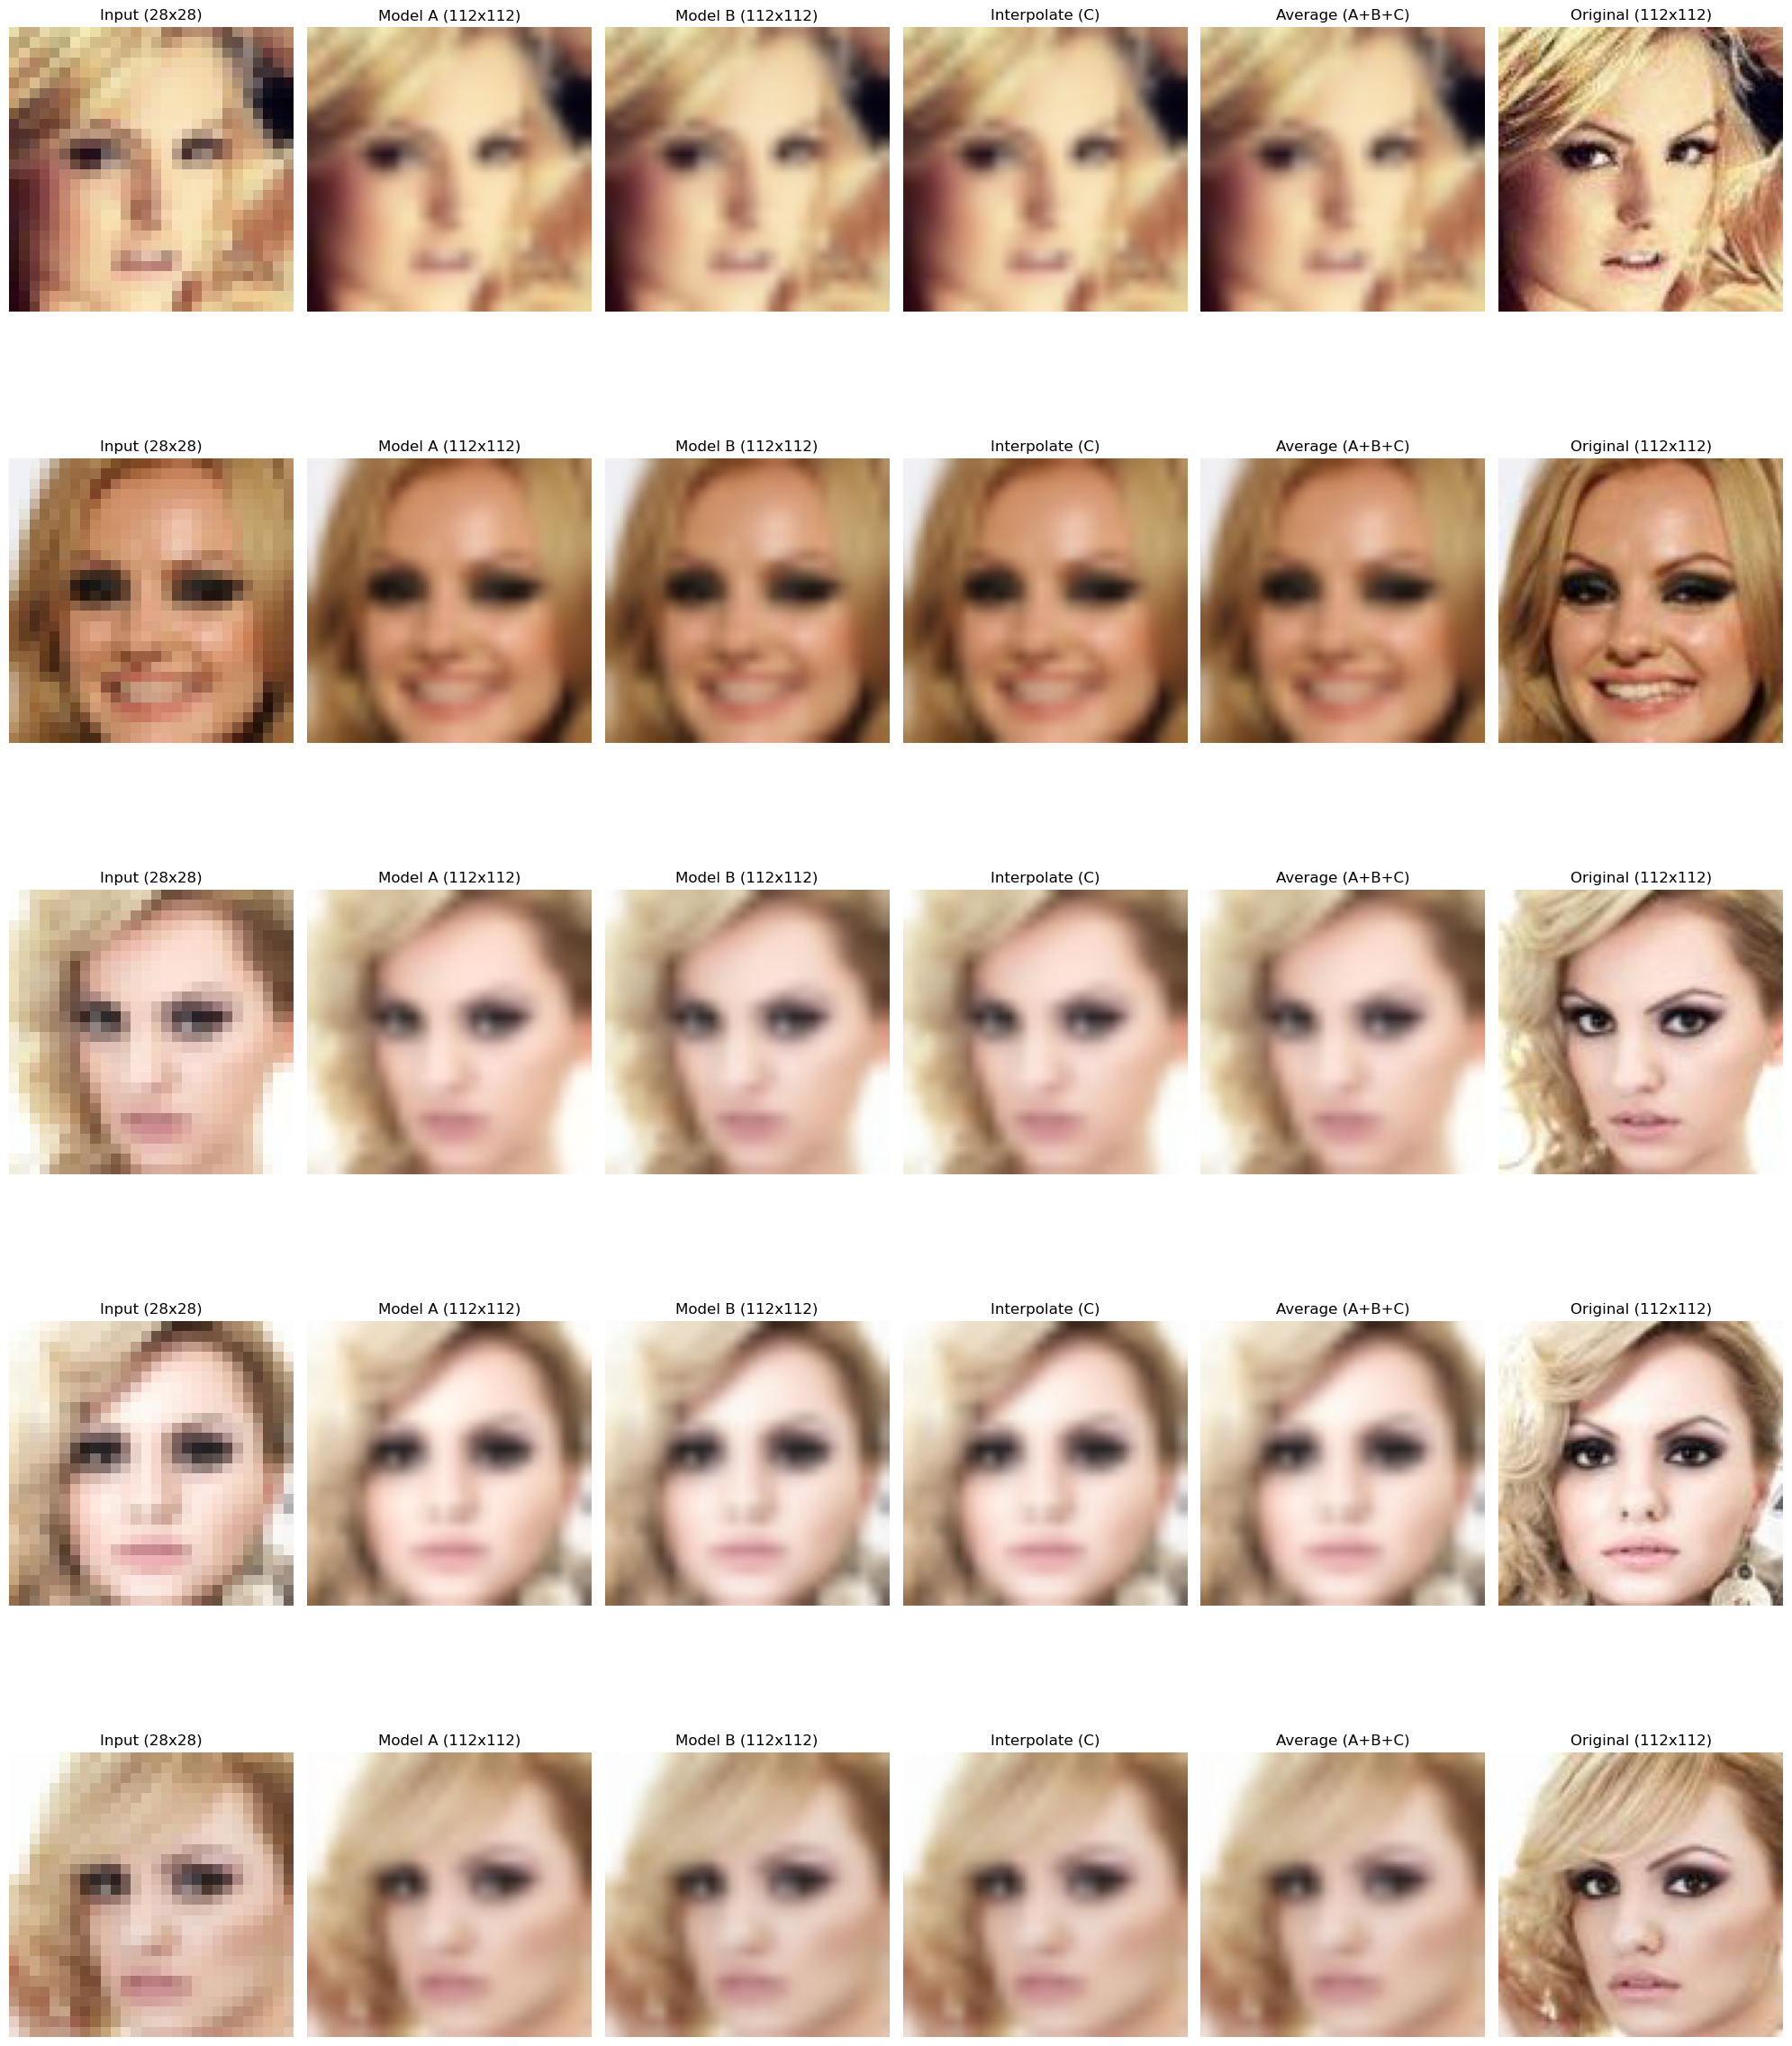

Test batch [1], MSE Loss: 0.0040
Test batch [2], MSE Loss: 0.0041
Test batch [3], MSE Loss: 0.0040
Test batch [4], MSE Loss: 0.0038
Test batch [5], MSE Loss: 0.0043
Test batch [6], MSE Loss: 0.0036
Test batch [7], MSE Loss: 0.0034
Test batch [8], MSE Loss: 0.0040
Test batch [9], MSE Loss: 0.0037
Test batch [10], MSE Loss: 0.0041
Test batch [11], MSE Loss: 0.0031
Test batch [12], MSE Loss: 0.0036
Test batch [13], MSE Loss: 0.0031
Test batch [14], MSE Loss: 0.0035
Test batch [15], MSE Loss: 0.0039
Test batch [16], MSE Loss: 0.0030
Test batch [17], MSE Loss: 0.0042
Test batch [18], MSE Loss: 0.0038
Test batch [19], MSE Loss: 0.0038
Test batch [20], MSE Loss: 0.0044
Test batch [21], MSE Loss: 0.0045
Test batch [22], MSE Loss: 0.0043
Test batch [23], MSE Loss: 0.0042
Test batch [24], MSE Loss: 0.0034
Test batch [25], MSE Loss: 0.0051
Test batch [26], MSE Loss: 0.0043
Test batch [27], MSE Loss: 0.0032
Test batch [28], MSE Loss: 0.0033
Test batch [29], MSE Loss: 0.0041
Test batch [30], MSE Lo

In [ ]:
# 저장된 상태 로드
save_dir = "model_checkpoints"

checkpoint_path_a = os.path.join(save_dir, f"model_a_112x112.pth")
checkpoint_path_b = os.path.join(save_dir, f"model_b_112x112.pth")

checkpoint_a = torch.load(checkpoint_path_a)
checkpoint_b = torch.load(checkpoint_path_b)

model_a.load_state_dict(checkpoint_a['model_state_dict'])
model_b.load_state_dict(checkpoint_b['model_state_dict'])

model_a.eval()  # 평가 모드로 전환
model_b.eval()

final_resolution=112
initial_resolution=28

with torch.no_grad():  # 학습이 아니라 테스트이므로 gradient 계산 비활성화
    for batch_idx, (test_data, original_data) in enumerate(data_loader):
        # 데이터 준비
        test_data = test_data.to(device)
        original_data = original_data.to(device)

        # 모델 출력
        output_a_step1 = model_a(test_data)
        output_a = model_a(output_a_step1)
        output_b = model_b(test_data)

        # 보조값 C 생성
        high_res_c = nn.functional.interpolate(test_data, size=(final_resolution, final_resolution), mode='bilinear', align_corners=False)

        # 평균값 계산
        avg_output = (output_a + output_b + high_res_c) / 3

        if batch_idx == 0:  # 첫 번째 배치에서만 시각화
            # 시각화
            plt.figure(figsize=(20, 25))
            for i in range(5):  # 처음 5개의 샘플만 시각화
                # Input (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 1)
                plt.imshow(test_data[i].permute(1, 2, 0).cpu().numpy())
                plt.title(f"Input ({initial_resolution}x{initial_resolution})")
                plt.axis('off')

                # Model A output (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 2)
                plt.imshow(output_a[i].permute(1, 2, 0).cpu().numpy())
                plt.title(f"Model A ({final_resolution}x{final_resolution})")
                plt.axis('off')

                # Model B output (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 3)
                plt.imshow(output_b[i].permute(1, 2, 0).cpu().numpy())
                plt.title(f"Model B ({final_resolution}x{final_resolution})")
                plt.axis('off')

                # Interpolated (C) (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 4)
                plt.imshow(high_res_c[i].permute(1, 2, 0).cpu().numpy())
                plt.title("Interpolate (C)")
                plt.axis('off')

                # Average output (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 5)
                plt.imshow(avg_output[i].permute(1, 2, 0).cpu().numpy())
                plt.title("Average (A+B+C)")
                plt.axis('off')

                # Original high resolution (컬러 이미지)
                plt.subplot(5, 6, i * 6 + 6)
                plt.imshow(original_data[i].permute(1, 2, 0).cpu().numpy())
                plt.title("Original (112x112)")
                plt.axis('off')

            plt.tight_layout()
            plt.show()

        # 성능 평가 (예: MSE 계산)
        mse_loss = nn.MSELoss()(avg_output, original_data)
        print(f"Test batch [{batch_idx + 1}], MSE Loss: {mse_loss.item():.4f}")


